In [2]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
# Add the datasets you want to analyze in 'dataset_dirnames'
# Change the directory names listed here by the ones set in your data folder.
# In this repository we include an example 'toy_dataset' that can be used to test the notebook.
dataset_dirnames = ['fsdataset'] #, 'apple_loops_db', 'mixcraft_loops_db', 'looperman'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)  # Load and clean datasets
# Add the datasets you want to analyze in 'methods_to_compare'
methods_to_compare = ['Percival14', 'Zapata14', 'Degara12', 'Bock15', 'RhythmTransform']
%matplotlib inline

# This notebook contains excerpts from the article: Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence Measure. In Proceedings of the Int. Conf. on Music Information Retrieval (ISMIR).
# License: CC-BY-4.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Overall tempo estimation accuracy

### NOTE: this notebook includes RhythmTransform method in the evaluation but only evaluates with Freesound loops dataset (4000 loops)

Similarly to previous tempo estimation works, we follow the methodology described by Gouyon et al. [1] to test the aforementioned algorithms against the four collected datasets. 
In addition the standard *Accuracy 1* and *Accuracy 2* measures (with 4% tolerance), we add an extra measure that we call *Accuracy 1e* and that represents the percentage of instances whose estimated BPM is exactly the same as the ground truth after rounding the estimated BPM to the nearest integer. Accuracy 1e is therefore more strict than Accuracy 1.
The reason why we added this extra accuracy measure is that, imagining a music creation context where loops can be queried in a database, it is of special relevance to get returned instances whose BPM exactly matches that specified as target.

The overall accuracy results show that Percival14 obtains the highest accuracy scores for all accuracy measures and all datasets except for the LOOP dataset, in which highest score for Accuracy 1 is obtained by Zapata14 (see Figure 1 in the cell below). Considering the data from all datasets at once, mean accuracy values for Percival14 range from 47% (Accuracy 1e) to 73% (Accuracy 2), with an average increase of 7% accuracy when compared with the second best-scored method. With a few exceptions, pairwise accuracy differences between Percival14 and the second best-scored method in all datasets and accuracy measures are statistically significant using McNemar's test and a significance value of $\alpha=0.01$ (i.e.,~$p \ll 0.01$). 
We also observe that accuracies for the APPL dataset tend to be higher than for other datasets. This can be explained by the fact that APPL contains professionally created and curated loops, while the other datasets contain user contributed content, not necessarily created by professionals (Mixcraft's loop library also contains content gathered from online repositories).

[1] Fabien Gouyon, Anssi Klapuri, Simon Dixon, Miguel Alonso, George Tzanetakis, Christian Uhle, and Pedro Cano. An Experimental Comparison ofAudio Tempo Induction Algorithms. IEEE Transactions on Audio, Speech and Language Processing, 14(5):1832–1844, 2006.

**Update**: we added the two other methods that Madmom's TempoDetector provides (Bock15ACF and Bock15DBN). These do not appear in the paper, and have only abnalysed FSL4 dataset, therefore we don't have results for the other datasets.




General tempo estimation results (fsdataset)
*********************************************


Method            Accuracy 1e   Accuracy 1   Accuracy 2   
----------------------------------------------------------
Percival14        43.90         54.45        70.52        
Bock15            22.74         37.03        65.04        
Degara12          30.22         52.98        60.46        
Zapata14          28.54         52.47        60.35        
RhythmTransform   13.05         18.17        37.14        


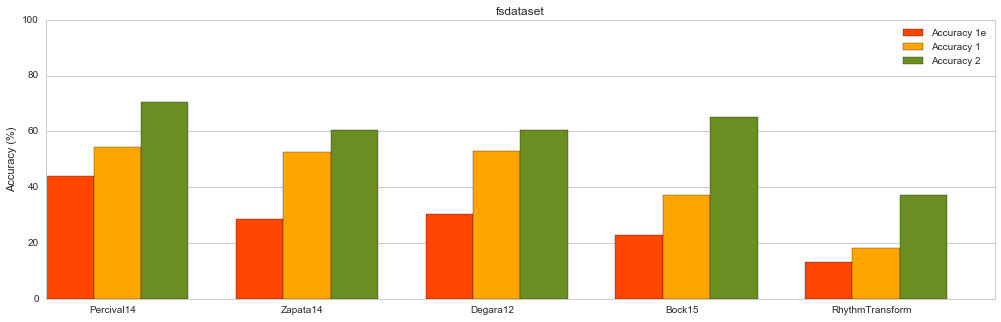


**Figure 1**: Overall tempo estimation accuracies.



General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method            Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
--------------------------------------------------------------------------
Percival14        43.90         54.45        70.52        56.29           
Degara12          30.22         52.98        60.46        47.88           
Zapata14          28.54         52.47        60.35        47.12           
Bock15            22.74         37.03        65.04        41.61           
RhythmTransform   13.05         18.17        37.14        22.79           


In [3]:
# Prepare figure
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = int(math.ceil(float(n_datasets)/2))
ncols = 1 if n_datasets < 2 else 2
fig1, axs = plt.subplots(nrows, ncols, figsize=(17, 5))

# Run analysis and plot results
all_datasets_method_results = dict()
for count, dataset in enumerate(datasets):
    print title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*')
    methods_to_compare = methods_to_compare
    table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [method]
            for accuracy_func in accuracy1e, accuracy1, accuracy2:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError:
            print "Warning: Skipping method %s (analsyis not found in dataset)" % method
            continue
    print ""
    print_table(table_header, table_rows, sort_column=3, highlight_max=True)
    
    if n_datasets == 1:
        ax = axs
    elif n_datasets == 2:
        ax = axs[count]
    else:
        ax_col=count/2
        ax_row=count%2
        ax = axs[ax_col,ax_row]
        
    N = len(methods_to_compare)
    ind = np.arange(N)
    accuracy_1e_means = [row[1] for row in table_rows]
    accuracy_1_means = [row[2] for row in table_rows]
    accuracy_2_means = [row[3] for row in table_rows]
    width = 0.25
    rects1 = ax.bar(ind, accuracy_1e_means, width, color=COLORS[0])
    rects2 = ax.bar(ind + width, accuracy_1_means, width, color=COLORS[1])
    rects3 = ax.bar(ind + 2*width, accuracy_2_means, width, color=COLORS[2])
    ax.set_title(dataset.short_name)
    ax.set_xticks(ind + 1.4 * width)
    ax.set_xticklabels([method for method in methods_to_compare], rotation=0)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy 1e', 'Accuracy 1', 'Accuracy 2'))
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)
    
plt.show()
figure_caption = """
**Figure 1**: Overall tempo estimation accuracies.
"""
IPython.display.display(IPython.display.Markdown(figure_caption))

# Show results for all datasets combined
print title("General tempo estimation results (ALL DATASETS)")
table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [method]
    for accuracy_measure, data in results.items():
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=4, highlight_max=True)

In [4]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset fsdataset
---------------------------------------


Measure: accuracy1e
                  Percival14   Zapata14    Degara12    Bock15       RhythmTransform   
--------------------------------------------------------------------------------------
Percival14        -            1.32e-74*   1.46e-60*   9.89e-120*   3.86e-200*        
Zapata14          1.32e-74*    -           0.000109*   2.51e-14*    8.54e-72*         
Degara12          1.46e-60*    0.000109*   -           7.78e-24*    3.72e-85*         
Bock15            9.89e-120*   2.51e-14*   7.78e-24*   -            4.12e-37*         
RhythmTransform   3.86e-200*   8.54e-72*   3.72e-85*   4.12e-37*    -                 

Measure: accuracy1
                  Percival14   Zapata14     Degara12     Bock15       RhythmTransform   
----------------------------------------------------------------------------------------
Percival14        -            0.0153       0.074        1.7e-73*     5.07e-243*        


## Accuracy vs confidence measure

Figure 2 (see cells below) shows the accuracy of the three best-scoring tempo estimation algorithms and the number of instances remaining in the dataset when filtering by different values of a confidence threshold $\gamma$.
As we expected, we can see how accuracy increases with $\gamma$ but the number of instances decreases.
Interestingly, we observe that the number of instances decays later for estimations performed with Percival14 algorithm than for the other algorithms.
This reflects the fact that Percival14 produces better BPM estimates.

In [5]:
# Confidence measure function
# NOTE: to speed up this process here we have already precomputed the effective start and end positions 
# acocrding to the envelope
def compute_confidence_measure(estimated_bpm,
                       duration_samples,
                       start_effective_duration,
                       end_effective_duration,
                       sample_rate=44100, beat_range=range(1, 128), k=0.5):
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

# Iterate over all instances in all datasets and for all methods
print 'Computing confidence measure values for all sounds in all datasets and for all methods...',
n_annotated = 0
for dataset in datasets:
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['confidence_ffont'] = compute_confidence_measure(
                    int(round(item['analysis'][method]['bpm'])),  
                    item['analysis']['durations']['length_samples'],
                    item['analysis']['durations']['start_effective_duration'], 
                    item['analysis']['durations']['end_effective_duration']
                )
                n_annotated += 1
            except KeyError:
                continue
print 'done! \n%i annotations done' % n_annotated
if n_annotated == 0:
    print 'It looks like no instances have been annotated. Make sure that the dataset has been properly analysed.'

Computing confidence measure values for all sounds in all datasets and for all methods... done! 
19720 annotations done



Confidence vs tempo estimation accuracy (fsdataset)
---------------------------------------------------



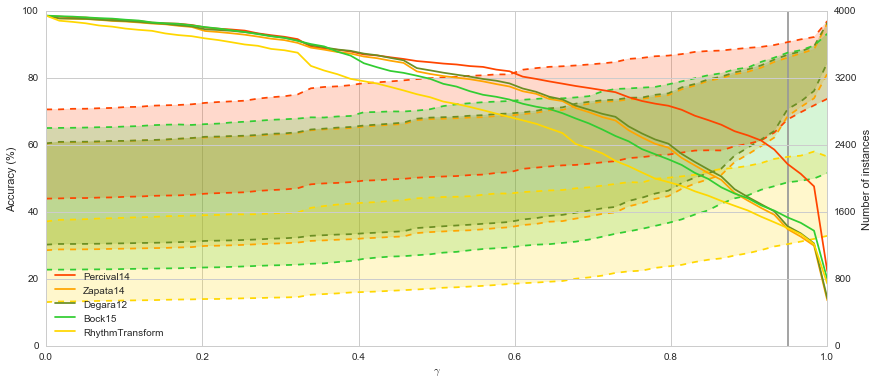

**Figure 2 - fsdataset **: Accuracy vs confidence measure for fsdataset dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    

In [6]:
# Now do all the plotting

for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()

    for count, method in enumerate(methods_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    plt.show()
    figure_caption = """**Figure 2 - %s **: Accuracy vs confidence measure for %s dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

### Accuracy results for confidence > 95%

Filtering by the confidence measure, a potential user searching for loops in a dataset could define a minimum threshold to get more accurate results at the expense of getting less loops returned. 
For instance, if we set a hard confidence threshold of $\gamma=0.95$, we find that the accuracies for Percival14 method range, on average, from 67% (Accuracy 1e) to 92% (Accuracy 2) while preserving an average of 52% of the instances. 
Interestingly enough, we observe that when setting that hard threshold, reported RekBox accuracies outperform these of Percival14 in all datasets, with an average increase ranging from 2% for Accuracy 2 to 14% for Accuracy 1e (all statistically significant with $p \ll 0.01$). 

We attribute this to the fact that RekBox seems to have a built-in confidence measure thresholding step in which the algorithm outputs 0 BPM when the analysis does not meet certain confidence requirements. Therefore, once filtering the datasets by $\gamma$ (even with small values), all those instances whose BPM estimation is 0 BPM get discarded. Nevertheless, it is also important to note that filtering with the hard threshold, RekBox only preserves an average of 31% of the instances (lower than the 52% reported above by Percival14).

In [7]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print 'Unable to compute results for method %s and dataset %s' % (method, dataset.short_name)
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print ''
print_table(table_header, table_rows)


Method            fsdataset                 
--------------------------------------------
Percival14        A=67.62 - 90.70%, N=55%   
Zapata14          A=68.63 - 86.15%, N=35%   
Degara12          A=70.73 - 86.97%, N=36%   
Bock15            A=48.89 - 87.60%, N=39%   
RhythmTransform   A=30.32 - 56.37%, N=36%   


In [8]:
# Run pairwise statistical tests when filtering by 95% confidence
alpha = 0.01
conf_threshold = 0.95

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    filtered_data_a = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    filtered_data_b = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    result = compute_mcnemar_test(accuracy_func(filtered_data_a, method_a), accuracy_func(filtered_data_b, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset fsdataset
---------------------------------------


Measure: accuracy1e
                  Percival14   Zapata14    Degara12    Bock15       RhythmTransform   
--------------------------------------------------------------------------------------
Percival14        -            5.19e-96*   2.19e-85*   1.22e-124*   5.76e-201*        
Zapata14          1.66e-10*    -           3.21e-15*   1.22e-83*    1.93e-139*        
Degara12          1.07e-13*    6.65e-29*   -           7.75e-87*    5.46e-155*        
Bock15            1.68e-11*    9.92e-08*   0.00715*    -            2.08e-86*         
RhythmTransform   1.95e-37*    1.34e-07*   1.09e-11*   0.000229*    -                 

Measure: accuracy1
                  Percival14   Zapata14    Degara12    Bock15      RhythmTransform   
-------------------------------------------------------------------------------------
Percival14        -            2.68e-08*   1.29e-06*   5.42e-51*   5.83e-186*        
Zapata14 

## Combined accuracy and confidence measure

Besides the overall accuracy measurements, we are also interested in observing how accuracy varies according to the confidence values that we estimate.
We can intuitively imagine that if we filter our datasets and only keep loops whose estimated confidence for the BPM prediction is above a certain confidence threshold, the overall accuracy results will increase. 
However, the higher we set the minimum confidence threshold, the smaller the size of filtered dataset will be.
Hence, we want to quantify the relation between the overall accuracy and the total number of music loops that remain in a dataset after filtering by minimum confidence.
To do that, given one of the aforementioned accuracy measures, we can define a minimum confidence threshold $\gamma$ and a function $A(\gamma)$ that represents overall BPM estimation accuracy when only evaluating loop instances whose estimated confidence value is above $\gamma$ for a given dataset and tempo estimation algorithm.
Similarly, we can define another function $N(\gamma)$ which returns the percentage of instances remaining in a dataset after filtering out those whose estimated confidence value (for a given tempo estimation method) is below $\gamma$. $A(\gamma)$ and $N(\gamma)$ can be understood as standard precision and recall curves, and therefore we can define a combined score measure $S(\gamma)$ doing the analogy with an f-measure computation:

$$ S(\gamma) = 2 \cdot \frac{A(\gamma) \cdot N(\gamma)}{A(\gamma) + N(\gamma)}.$$

An overall score for a given dataset, tempo estimation algorithm and accuracy measure can thus be given by taking the mean of $S(\gamma)$, $\bar S$. After computing $\bar S$ with our data, we again find that Percival14 obtains the best score in all datasets and for all accuracy measures (i.e.~for $A(\gamma)$ computed with Accuracy 1e, Accuracy 1 or Accuracy 2). This means that Percival14 offers the overall best balance between estimation accuracy and number of preserved instances in the dataset when filtering by a minimum confidence threshold.

In [9]:
# NOTE: To run this cell, confidence measures need to be computed first (see cells above)

def overall_method_score(accuracies, counts, dataset_size):
    """
    We normalize the counts to the dataset size so scores provided by datasets of different sizes are comparable.
    We also normalize accuracy values to go from 0 to 1 instead of from 0 to 100.
    Finally we divide the result by the number of bins of the histogram so that using histograms of different resolution
    should return similar results.
    """
    overall_score = 0.0
    length = len(counts)  # Should be the same as len(accuracies)
    for i in range(length):
        overall_score += 2 * ((float(counts[i])/dataset_size) * (float(accuracies[i])/100)) / ((float(counts[i])/dataset_size) + (float(accuracies[i])/100))
    return overall_score/length

for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print title('Combined score results for %s' % accuracy_func.__name__)
    table_header = ['Method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method in methods_to_compare:
        table_row = list()
        table_row.append(method)
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                try:
                    filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                    if filtered_data:
                        accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    else:
                        accuracies.append(0.00000001)  # Use very small number to avoid division by 0, in any case counts will be 0 to so overall_score will be 0
                    counts.append(len(filtered_data))
                except IndexError:
                    raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method            fsdataset   
------------------------------
Percival14        0.62        
Degara12          0.49        
Zapata14          0.47        
Bock15            0.41        
RhythmTransform   0.28        

Combined score results for accuracy1
------------------------------------

Method            fsdataset   
------------------------------
Percival14        0.70        
Degara12          0.66        
Zapata14          0.65        
Bock15            0.53        
RhythmTransform   0.33        

Combined score results for accuracy2
------------------------------------

Method            fsdataset   
------------------------------
Percival14        0.80        
Bock15            0.72        
Degara12          0.70        
Zapata14          0.70        
RhythmTransform   0.52        
